In [408]:
using JuMP, Gurobi, Ipopt,AmplNLWriter, NLopt
using Mosek, Cbc
    k = 2              # number of waypoints
    T = zeros(Int,k)   # vector of timepoints
    xw = zeros(2,k)    # vector of waypoint locations

    T[1] = 1
    T[2] = 20

    # define waypoints
    xw = [ 1   4
           1   3]
   
    A = [1 0;
        -1 0;
        0 1;
        0 -1;]
    b = [xw[1,k] - 1.01; -(xw[1,k] + 1.01); xw[2,k] - 1.01; -(xw[2,k] + 1.01)];

In [557]:
    m = Model(solver = GurobiSolver(OutputFlag=0))
    @variable(m, x[1:2,1:T[k]])  # resulting position
    @variable(m, v[1:2,1:T[k]])  # resulting velocity
    @variable(m, u[1:2,1:T[k]])  # thruster input
    @variable(m, inTarget[1:4, 1:T[k]], Bin)
    @variable(m, timeStep[1:T[k]], Bin)

    # satisfy the dynamics (with zero initial velocity)
    @constraint(m, v[:,1] .== [0;0])

    for t in 1:T[k]-1
        @constraint(m, x[:,t+1] .== x[:,t] + v[:,t])
        @constraint(m, v[:,t+1] .== v[:,t] + u[:,t])
    end

    # hit all the waypoints
    
    for t in [1 k]
        @constraint(m, x[:,T[t]] .== xw[:,t])
    end

    #@constraint(m, (x[1,t]) <= 2.5 + 1000*inTarget[1,t])
    #@constraint(m, -(x[1,t]) <= -3.5 + 1000*obstacle[2,t])
    #@constraint(m, (x[2,t]) <= 2.5 + 1000*obstacle[3,t])
    #@constraint(m, -(x[2,t]) <= -3.5 + 1000*obstacle[4,t])
    #for t in 2:T[k]
        @constraint(m, (x[1,1]) - 2.5 <= 1000*inTarget[1,1])
    #end
    #for t in 1:T[k]
    #    @constraint(m, sum(v[:,t].^2) <= 1)
    #end

    # minimize 2-norm (THIS IS LEAST-SQUARES)
    λ = 100
    @objective(m, Min, sum(u.^2) + λ*sum((x[:,T[2:k]]-xw[:,2:k]).^2))
    solve(m)
    
    xopt = getvalue(x)

2×20 Array{Float64,2}:
 1.0  1.0  1.0256   1.07539  1.14794  …  3.27596  3.51494  3.75676  4.0
 1.0  1.0  1.01707  1.05026  1.09862     2.51731  2.67662  2.83784  3.0

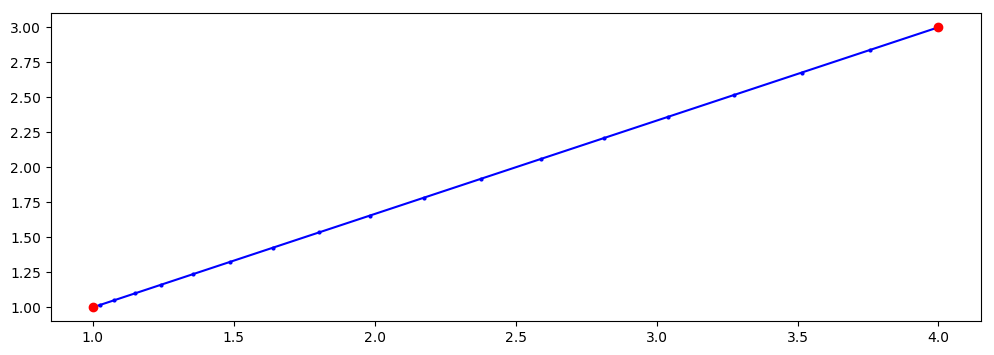

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3332bef10>

In [558]:
using PyPlot
figure(figsize=(12,4))
plot( xopt[1,:][:], xopt[2,:][:], "b.-", markersize=4 )
plot( xw[1,:], xw[2,:], "r.", markersize=12 )

In [559]:
getobjectivevalue(m)

0.0061640587946385494

In [560]:
x = (getvalue(x))

2×20 Array{Float64,2}:
 1.0  1.0  1.0256   1.07539  1.14794  …  3.27596  3.51494  3.75676  4.0
 1.0  1.0  1.01707  1.05026  1.09862     2.51731  2.67662  2.83784  3.0

In [561]:
inT = getvalue(inTarget)

4×20 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [555]:
println(sum(inT[i,:] for i in 1:4))

[4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0]


In [556]:
getvalue(timeStep)'

1×20 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0